In [98]:
# miscellaneous
from tqdm import tqdm
import time
import joblib
# Analysis
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns


# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer, PolynomialFeatures, QuantileTransformer

# metrics
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, balanced_accuracy_score, f1_score, precision_score, recall_score, classification_report


# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


In [99]:
# Select columns
def select_columns(dataset, columns_to_keep):
    """Filters columns of `dataset` to keep only those specified by the `columns_to_keep` paramater

    Args:
        dataset (Pandas DataFrame): Dataset to filter
        columns_to_keep ( regex expression, str): columns names to keep

    Returns:
        Pandas Dataframe: Dataset with selected column(s)
    """
    column_filter = dataset.columns.str.replace(
        'android.sensor.|mean|std|min|max|#', '', regex=True).str.fullmatch(columns_to_keep)

    return dataset.loc[:, column_filter]


# drop column(s) based on missing value percentage
def drop_col_percent_na(dataset, threshold):
    """Drop columns missing value greater than `threshold`

    Args:
        dataset (Pandas Dataframe): Dataframe from which to drop columns
        threshold (float/int): Percentage of NaN beyong which a column should be dropped (from 1 to 100)

    Returns:
        Pandas Dataframe: Dataset with dropped column(s)
    """
    to_drop = (dataset.isnull().sum()/dataset.shape[0]*100) > threshold

    return dataset.loc[:, ~to_drop]


# Split train test sets
def split_train_test(data, upper_boundary=1, lower_boundary=3, nb_users_test=3):
    """Split `data` into train and test sets based on users. Users with highest number of
    records as well as very few numbers of records are excluded from being choosen for the test set.

    Args:
        data (Pandas DataFrame): Dataset to split
        upper_boundary (int, optional): Controls k-number of users with high number of records to exclude. Defaults to 1.
        lower_boundary (int, optional): Controls k-number of users with low number of records to exclude. Defaults to 3.
        nb_users_test (int, optional): Number of users to include in the test set. Defaults to 3.

    Returns:
        Tuple(Pandas DataFrame, Pandas DataFrame): Both train and test sets
    """
    np.random.seed(0)

    # number of records per user (sorted from highest to lowest)
    user_dist = data.user.value_counts()

    # array of users from which to choose the ones going into test set
    to_choose_from = user_dist[upper_boundary: len(
        user_dist) - lower_boundary].index

    # users in test set
    test_users = np.random.choice(to_choose_from, nb_users_test, replace=False)

    # splitting into train and test sets
    train = pd.DataFrame()
    test = pd.DataFrame()
    for _, row in data.iterrows():
        if row["user"] in test_users:
            test = pd.concat([test, row], axis=1)

        else:
            train = pd.concat([train, row], axis=1)

    return train.T, test.T


# 
def split_train_test2(df, test_users):
    train = pd.DataFrame()
    test = pd.DataFrame()
    for _, row in df.iterrows():
        if row["user"] in test_users:
            test = pd.concat([test, row], axis=1)

        else:
            train = pd.concat([train, row], axis=1)

    return train.T, test.T



# Reduce target cardinality(from 5 to 3)
def encode_target(x):
    if x == 'Walking':
        return 'walking'
    elif x == 'Car' or x == 'Bus' or x == 'Train':
        return 'car_bus_train'
    else:
        return 'still'



# Preprocessing + model pipeline
def pipelines(models):
    """Create pipelines made up preprocessors(Imputer, StandardScaler) and models

    Args:
        models (dict): A dictionary of model's name as key and sklearn corresponding algorithm as value

    Returns:
        dict: A dictionary of model's name as key and pipeline (preprocessing + model) as value
    """

    # Preprocessors
    # imputer = IterativeImputer(random_state=0, max_iter=30)
    imputer = KNNImputer()
    # imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()
    qtransf = QuantileTransformer(output_distribution='normal')

    # Pipelines of preprocessor(s) and models
    pipes = {name: Pipeline([
        ('imputer', imputer),
        ('scaler', scaler),
        ('qtransf', qtransf), 
        ('model', model)
    ]) for name, model in models.items()}

    return pipes


# Model performance
def perfomance(pipes, X_train, y_train, X_test, y_test):
    """Compute mean and std of cross validation scores, accuracy on test set
       as well as training and predicting time

    Args: pipes(dict); as defined in `pipelines` function.
          X_train, y_train; training sets
          X_test, y_test; test sets

    Returns:
        Pandas Dataframe: Dataframe of computed performance metrics sorted by accuracy on test set
    """
    results = pd.DataFrame()

    for i in tqdm(range(len(pipes))):

        name = list(pipes.keys())[i]
        model = list(pipes.values())[i]

        # training time
        t0 = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - t0

        # predicting time
        t0 = time.time()
        preds = model.predict(X_test)
        pred_time = time.time() - t0

        # cross validation
        # scores = cross_val_score(model, X_train, y_train)

        # append to results
        results = pd.concat([results, pd.DataFrame({'name': [name],
                                                    # 'mean_score': [scores.mean()],
                                                    # 'std_score':[scores.std()],
                                                    'test_accuracy': [accuracy_score(y_test, preds)],
                                                    'balanced_accuracy':[balanced_accuracy_score(y_test, preds)],
                                                    # 'f1_score': [f1_score(y_test, preds)], 
                                                    # 'precision': [precision_score(y_test, preds)], 
                                                    # 'recall': [recall_score(y_test, preds)],
                                                    'training_time': [train_time],  
                                                    'predicting_time': [pred_time]})
                             ])

    return results.sort_values(by='balanced_accuracy', ascending=False)


# Load Data

In [100]:
# Load data
data = pd.read_csv('data/dataset_5secondWindow.csv')

df = data.copy()


# Explore

### Overiew

In [101]:
# overview
data.head()

,Unnamed: 0,id,time,activityrecognition#0,activityrecognition#1,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.game_rotation_vector#mean,...,sound#mean,sound#min,sound#max,sound#std,speed#mean,speed#min,speed#max,speed#std,target,user
0,0,16170,78.0,NaN,100.0,9.811476,9.758895,9.849411,0.014626,0.029340,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,U12
1,1,15871,145.0,NaN,100.0,9.939207,7.707437,17.146631,1.775944,0.999925,...,89.200210,89.065143,89.335277,0.191013,16.539349,16.539349,16.539349,0.628595,Car,U12
2,2,16811,150.0,NaN,100.0,9.827178,9.804817,9.849262,0.011199,0.665215,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,U12
3,3,15831,105.0,NaN,77.0,9.673039,7.659674,12.304298,0.862553,0.996221,...,87.470377,87.470377,87.470377,2.284186,17.739895,17.739895,17.739895,0.628595,Car,U12
4,4,876,77.0,NaN,100.0,9.993466,8.965621,10.891645,0.504117,0.563792,...,89.770732,89.770732,89.770732,0.006389,9.000000,9.000000,9.000000,NaN,Car,U1


In [102]:
# numbers of columns/rows
data.shape

(5893, 71)

### Users

In [103]:
# How many records per user
data.user.value_counts(normalize=True)

U1     0.419141
U12    0.139148
U10    0.090107
U7     0.067368
U3     0.056168
U6     0.047344
U2     0.045987
U4     0.038520
U8     0.036314
U11    0.028339
U13    0.015272
U9     0.013406
U5     0.002885
Name: user, dtype: float64

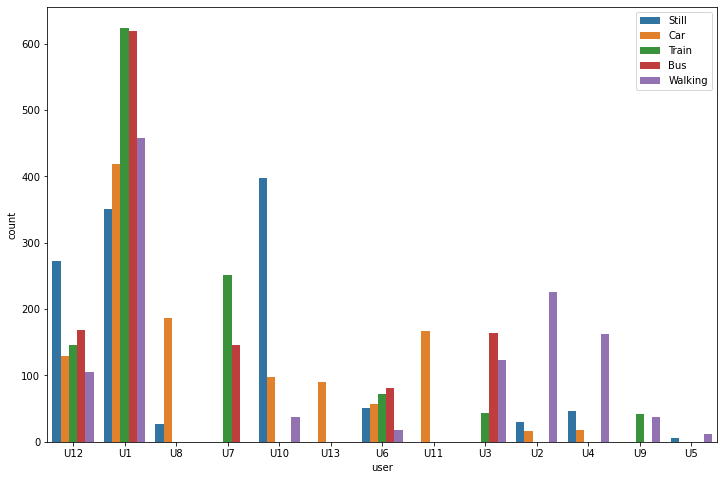

In [104]:
plt.figure(figsize=(12, 8))
sns.countplot(x = data.user, hue= data.target)
plt.legend(loc='upper right')


### Missing values

<AxesSubplot:>

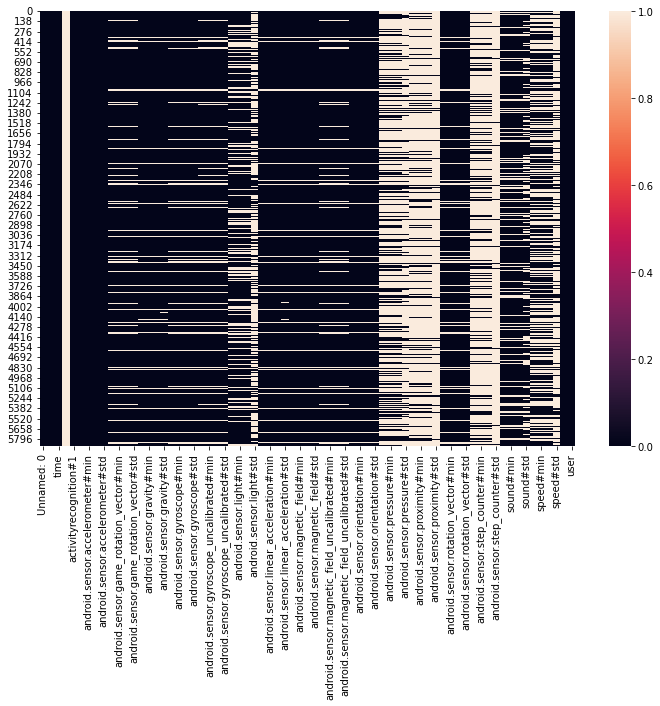

In [105]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull())

#### Distribution of features

In [106]:
# to_remove = ['Unnamed: 0', 'id', 'time', 'activityrecognition#0','activityrecognition#1']
# data2 = data.drop(columns=to_remove)
# data2['target'] = data2['target'].apply(encode_target)
# data2.shape

In [107]:
# to_remove = ['Unnamed: 0', 'id', 'time', 'activityrecognition#0','activityrecognition#1']
# data2 = data.drop(columns=to_remove)
# data2['target'] = data2['target'].apply(encode_target)
# for col in data2.columns[8:16]:
#     plt.figure(figsize=(12, 8))
#     sns.histplot(x = data2[col], hue= data2.target.astype(str), kde=True)
#     plt.show()


# Preprocessing

In [108]:
'accelerometer|sound|orientation|linear_acceleration|speed|gyroscope|rotation_vector|game_rotation_vector|gyroscope_uncalibrated|target|user'

'accelerometer|sound|orientation|linear_acceleration|speed|gyroscope|rotation_vector|game_rotation_vector|gyroscope_uncalibrated|target|user'

In [109]:
# Select columns to use
keep_columns = 'accelerometer|sound|gyroscope|target|user'
df = select_columns(df, keep_columns)
df.shape

(5893, 14)

In [110]:
# Drop columns with high percentage of missing values
# df = drop_col_percent_na(df, 50)
# df.shape

# Train Test split

In [111]:
# Train split
train, test = split_train_test2(df, ['U12', 'U6'])

In [112]:
test.user.unique()

array(['U12', 'U6'], dtype=object)

In [113]:
train.user.unique()

array(['U1', 'U8', 'U7', 'U10', 'U13', 'U11', 'U3', 'U2', 'U4', 'U9',
       'U5'], dtype=object)

In [114]:
train.target.value_counts(normalize=True)

Walking    0.219858
Car        0.207343
Train      0.200459
Bus        0.193784
Still      0.178557
Name: target, dtype: float64

In [115]:
test.target.value_counts(normalize=True)

Still      0.293904
Bus        0.226570
Train      0.198362
Car        0.169245
Walking    0.111920
Name: target, dtype: float64

In [116]:
# Features target separation
X_train, y_train = train.drop(columns=['target', 'user']), train['target']

X_test, y_test = test.drop(columns=['target', 'user']), test['target']

In [117]:
# encode target
# y_train = train['target'].apply(lambda x: 1 if x == 'Walking' else 0)
# y_test = test['target'].apply(lambda x: 1 if x == 'Walking' else 0)

y_train = train['target'].apply(encode_target)
y_test = test['target'].apply(encode_target)

In [118]:
print(f'train_size: {len(y_train)}\n{y_train.value_counts(normalize=True)}\n\n')
print(f'test_size: {len(y_test)}\n{y_test.value_counts(normalize=True)}')


train_size: 4794
car_bus_train    0.601585
walking          0.219858
still            0.178557
Name: target, dtype: float64


test_size: 1099
car_bus_train    0.594177
still            0.293904
walking          0.111920
Name: target, dtype: float64


# Training

In [119]:
# Pipelines (preprocessing + model)
models = {'rf': RandomForestClassifier(random_state=0),
          "gb": GradientBoostingClassifier(random_state=0, learning_rate=0.01),
          'dt': DecisionTreeClassifier(),
          'extraT': ExtraTreesClassifier(random_state=0),
        #   'xgb':XGBClassifier(),
        #    'logR':LogisticRegression(),
          'svm': SVC(random_state=0, C=0.1), 
          'mlp': MLPClassifier(random_state=0, max_iter=1000),
          'sgd': SGDClassifier(random_state=0)
          }


pipes = pipelines(models)


# Performance

results = perfomance(pipes, X_train.values, y_train.values, X_test.values, y_test.values)
print('Performance: \n', results)

100%|██████████| 7/7 [00:34<00:00,  4.87s/it]

Performance: 
      name  test_accuracy  balanced_accuracy  training_time  predicting_time
0      gb       0.968153           0.961522       6.746885         0.722606
0     svm       0.939035           0.948429       1.595546         0.972440
0  extraT       0.915378           0.927856       1.471419         0.707070
0      rf       0.914468           0.923581       2.208615         0.690592
0     mlp       0.834395           0.845691      14.809402         0.646673
0      dt       0.787989           0.807956       1.169172         0.670211
0     sgd       0.535032           0.580630       0.992697         0.651982


In [138]:
model = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
# imputer = IterativeImputer()
imputer = KNNImputer()
# imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
qtransf = QuantileTransformer(output_distribution='normal')

pipe = Pipeline([
    ('imputer', imputer),
    # ('scaler', scaler),
    #  ('quantile', qtransf),
    ('model', model)])

               precision    recall  f1-score   support

car_bus_train       0.98      0.97      0.98       653
        still       0.97      0.97      0.97       323
      walking       0.93      0.94      0.94       123

     accuracy                           0.97      1099
    macro avg       0.96      0.96      0.96      1099
 weighted avg       0.97      0.97      0.97      1099



<Figure size 864x576 with 0 Axes>

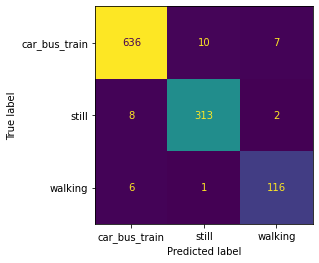

In [139]:

pipe.fit(X_train.values, y_train.values)
preds = pipe.predict(X_test.values)
plt.figure(figsize = (12, 8))
ConfusionMatrixDisplay.from_predictions(y_test.values, preds, colorbar=False)
print(classification_report(y_test, preds))

# Save model and example user file

In [140]:
# joblib.dump(pipe, 'model.joblib')

In [141]:
# df[df.user == 'U12'].drop(columns = ['user', 'target']).to_csv('example_file_user.csv')


In [142]:
df[df.user == 'U12'].target

0         Still
1           Car
2         Still
3           Car
7           Bus
18      Walking
22        Still
23        Still
44        Train
55        Still
75          Bus
79          Bus
80        Train
86        Still
97          Car
98          Car
99          Car
114       Still
117       Still
125         Bus
127       Still
128         Car
133         Bus
135       Train
138     Walking
145       Still
151       Still
155       Train
164       Still
165       Still
181       Still
184         Car
195       Train
198       Train
201       Still
215       Still
220     Walking
222       Train
226         Car
237         Bus
245     Walking
246       Still
259       Train
283       Still
289         Car
292       Still
300       Train
316       Still
332       Still
346     Walking
357       Train
362       Still
368         Bus
384         Car
391         Bus
403       Still
421       Still
425         Bus
426     Walking
427       Still
430         Bus
439         Bus
455     